<a href="https://colab.research.google.com/github/Jonyango/Final_Project/blob/main/Deployment_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Importing the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import tensorflow as tf

import keras
from keras.preprocessing import text,sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LSTM, Dropout, SpatialDropout1D, Embedding, MaxPooling1D, Bidirectional


from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle



In [ ]:
#loading the data
real_news = pd.read_csv('/content/gdrive/My Drive/fake_news_data/True.csv')
fake_news = pd.read_csv('/content/gdrive/My Drive/fake_news_data/Fake.csv')

In [ ]:
real_news.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [ ]:
fake_news.tail()

,title,text,subject,date
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


In [ ]:
#looking at the shapes of the dataset
real_news.shape

(21417, 4)

In [ ]:
fake_news.shape

(23481, 4)

In [ ]:
# adding a new column that will help with concatinating the dataset
fake_news['target']=0
real_news['target']=1

In [ ]:
real_news.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
#merging the fake_news dataset and the real_news dataset
news_data = pd.concat([real_news, fake_news], ignore_index=True, sort=False)

In [ ]:
#looking at the merged dataset
news_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
news_data.tail()

,title,text,subject,date,target
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [ ]:
news_data.shape

(44898, 5)

In [ ]:
#checking to see if we have any null values in the different columns
news_data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [ ]:
#EDA
print(news_data["target"].value_counts())


0    23481
1    21417
Name: target, dtype: int64


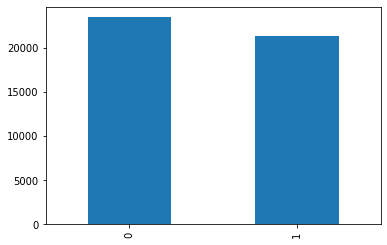

In [ ]:
#looking at the distribution of the classes i.e real news and fake news
news_data['target'].value_counts().plot(kind="bar")

The data is almost balanced with fake news being over 20000 and real news being at around 20000

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of News across Real News and Fake News')

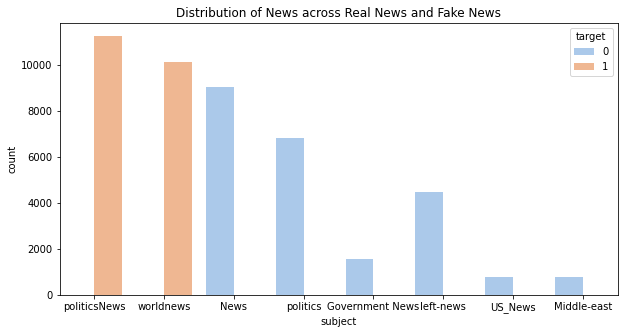

In [ ]:
# looking at the distribution of the news across real news and fake news
print(news_data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=news_data, palette="pastel")
plt.title("Distribution of News across Real News and Fake News")

In [ ]:
#Data Cleaning
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [ ]:
news_data.nunique()

title      38729
text       38646
subject        8
date        2397
target         2
dtype: int64

In [ ]:
news_data=news_data.drop_duplicates()
news_data = news_data.reset_index(drop=True)

In [ ]:
news_data.shape

(44689, 5)

In [ ]:
# defining some utility functions that will helps us with further help us with preprocessing the data
!pip install bs4

In [ ]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from bs4 import BeautifulSoup
#Removal of HTML Contents
def remove_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
  return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
  return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):

  final_text = []
  text = nltk.word_tokenize(text)

  for word in text:
      if word not in set(stopwords.words('english')):
          lemma = nltk.WordNetLemmatizer()
          word = lemma.lemmatize(word) 
          final_text.append(word)
  return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text


In [ ]:
#combine the title, the tsubject, the text and the date as one single text
news_data['text']= news_data['subject'] + " " + news_data['title'] + " " + news_data['text']

# delete the columnns that we have already combined
del news_data['title']
del news_data['subject']
del news_data['date']

#looking at the modified dataset
news_data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
first_text= news_data.text[0]

first_text

'politicsNews As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional incr

In [ ]:
#applying the preprocessing function to our text column in the dataset
# news_data['text'] =news_data['text'].apply(preprocess_text_data)
first_split = news_data.iloc[0:11175, : ]
second_split = news_data.iloc[11175:22351, : ]
third_split = news_data.iloc[22351:33556, :]
fourth_split= news_data.iloc[33556:, :]


In [ ]:
print(first_split.shape)
print(second_split.shape)
print(third_split.shape)
print(fourth_split.shape)

# First_split['text'] = First_split['text'].apply(cleaning)


(11175, 2)
(11176, 2)
(11205, 2)
(11133, 2)


In [ ]:
first_split['text'] =first_split['text'].apply(cleaning)

In [ ]:
second_split['text'] =second_split['text'].apply(cleaning)

In [ ]:
third_split['text'] =third_split['text'].apply(cleaning)

In [ ]:
fourth_split['text'] =fourth_split['text'].apply(cleaning)

In [ ]:
# Appending the preprocessed data
new_df = pd.DataFrame()
new_df = first_split.append(second_split)
new_df = new_df.append(third_split)
new_df = new_df.append(fourth_split)


new_df.shape

(44689, 2)

In [ ]:
new_df.head()

,text,target
0,politicsNews As U S budget fight loom Republic...,1
1,politicsNews U S military accept transgender r...,1
2,politicsNews Senior U S Republican senator Let...,1
3,politicsNews FBI Russia probe helped Australia...,1
4,politicsNews Trump want Postal Service charge ...,1


In [ ]:
new_df.tail()

,text,target
44684,Middle east McPain John McCain Furious That Ir...,0
44685,Middle east JUSTICE Yahoo Settles E mail Priva...,0
44686,Middle east Sunnistan US Allied Safe Zone Plan...,0
44687,Middle east How Blow Million Al Jazeera Americ...,0
44688,Middle east U S Navy Sailors Held Iranian Mili...,0


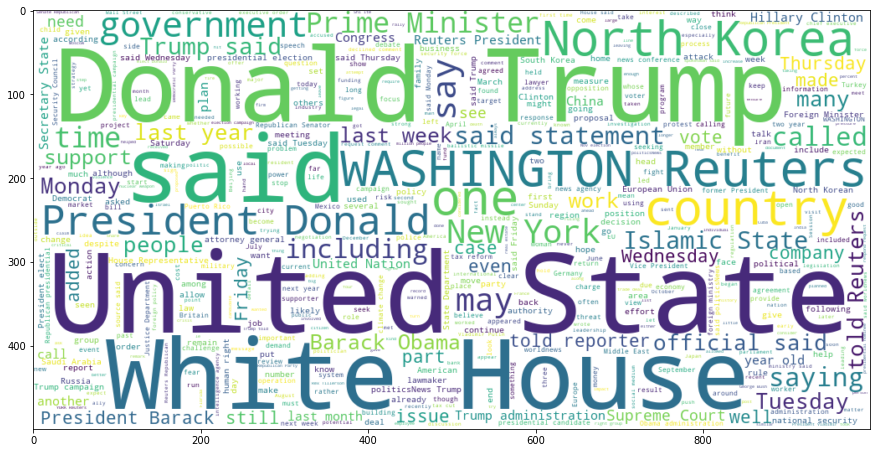

In [ ]:
# Visualizing the new data
#generating word cloud for real news
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
word_count = WordCloud(background_color="white",max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(new_df[new_df.target == 1].text))
plt.imshow(word_count , interpolation = 'bilinear')

In [ ]:
#wordcloud visualization for fake news
plt.figure(figsize = (15,15))
word_count = WordCloud(background_color="white",max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(new_df[new_df.target == 0].text))
plt.imshow(word_count , interpolation = 'bilinear')

In [ ]:
# visualizing the Number of words in each text data

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=new_df[new_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len, color='orange')
ax1.set_title('Fake news text data')
text_len=new_df[new_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len, color='black')
ax2.set_title('Real news text data')
fig.suptitle('Words in the texts')
plt.show()

The graph above shows us a bit of difference in the number of words. 500 words are most common in real news category while around 250 words are most common in fake news category


In [ ]:
# Model Creation
#splititng the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(new_df['text'], new_df['target'], random_state=0)

In [ ]:
#mapping of original word to number through tokenizing
# keeping the length of news to 300 words and padding the ones with less than 300 word as well cutting out
max_features = 10000
max_len = 300

In [ ]:
#create a tokenizer object
tokenizer = text.Tokenizer(num_words = max_features)

In [ ]:
#tokenizing and padding our training data
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)

X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)


In [ ]:
#tokenizing and padding our testing data
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [ ]:
# saving the tokenizer object
tokenizer_file = "tokenizer.pkl"
pickle.dump(tokenizer, open(tokenizer_file, "wb"))

In [ ]:
batch_size = 128
epochs = 10
embed_size =100

In [ ]:
# Building a LSTM Model
model = Sequential()
# building a non-trainable embedding layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=max_len, trainable=False))

model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#compile the LSTM model
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#looking at the summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
# Define an early stopping callback for the bilstm and lstm model
early_stopping = EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=4,
  verbose=0,
  mode="auto",
)

In [ ]:
# Training Our Model
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])

Epoch 1/10
262/262 [==============================] - 535s 2s/step - loss: 0.4892 - accuracy: 0.7421 - val_loss: 0.4818 - val_accuracy: 0.5767
Epoch 2/10
262/262 [==============================] - 531s 2s/step - loss: 0.3176 - accuracy: 0.8574 - val_loss: 0.2110 - val_accuracy: 0.9311
Epoch 3/10
262/262 [==============================] - 531s 2s/step - loss: 0.1758 - accuracy: 0.9367 - val_loss: 0.0446 - val_accuracy: 0.9808
Epoch 4/10
262/262 [==============================] - 533s 2s/step - loss: 0.0415 - accuracy: 0.9856 - val_loss: 0.0296 - val_accuracy: 0.9901
Epoch 5/10
262/262 [==============================] - 533s 2s/step - loss: 0.0381 - accuracy: 0.9869 - val_loss: 0.0265 - val_accuracy: 0.9903
Epoch 6/10
262/262 [==============================] - 531s 2s/step - loss: 0.0342 - accuracy: 0.9882 - val_loss: 0.0241 - val_accuracy: 0.9912
Epoch 7/10
262/262 [==============================] - 529s 2s/step - loss: 0.0282 - accuracy: 0.9904 - val_loss: 0.0232 - val_accuracy: 0.9915

In [ ]:
loss,train_data_acc= model.evaluate(X_train, y_train)
print(" Training Data Accuracy: {:.2f}".format(train_data_acc))

1048/1048 [==============================] - 128s 122ms/step - loss: 0.0151 - accuracy: 0.9956
 Training Data Accuracy: 1.00


In [ ]:
loss, test_data_acc = model.evaluate(X_test,y_test)
print("Testing Data Accuracy: {:.2f}".format(test_data_acc))

350/350 [==============================] - 43s 123ms/step - loss: 0.0267 - accuracy: 0.9914
Testing Data Accuracy: 0.99


In [ ]:
pred = model.predict_classes(X_test)
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99      5870
        Real       1.00      0.99      0.99      5303

    accuracy                           0.99     11173
   macro avg       0.99      0.99      0.99     11173
weighted avg       0.99      0.99      0.99     11173



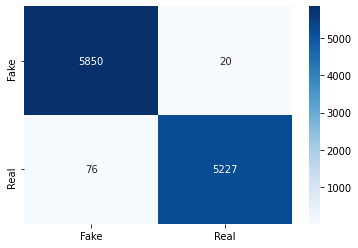

In [ ]:
 # Plot a confusion matrix of the predictions
confusion_mx = confusion_matrix(y_test, pred)
sns.heatmap(confusion_mx, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'], annot=True, fmt=".0f", cmap=plt.cm.Blues)